# SVDDnegEps

The SVDDnegEps is a one-class classifier and based on the SVDDneg. The idea is to extend the radius by some epsilon $\varepsilon \in \mathbb{R}^+$ and still correctly classify outliers.

The optimization problem is

\begin{aligned}
P: \ & \underset{R, a, \xi}{\text{min}}
& & R^2 + C_1 \sum_i \xi_i  + C_2 \sum_l \xi_l\\
& \text{s.t.}
& & \left\Vert \Phi(x_{i}) - a \right\Vert^2\,{\color{red}{+\,\varepsilon}}\, \leq R^2 + \xi_i, \; ∀ i \\
& & & \left\Vert \Phi(x_{l}) - a \right\Vert^2 \leq R^2 - \xi_l, \; ∀ l\\
& & & \xi_i, \geq 0, \; ∀ i\\
& & & \xi_l, \geq 0, \; ∀ l
\end{aligned}

with radius $R$ and center of the hypersphere $a$, a slack variable $\xi$, and a mapping into an implicit feature space $\Phi$.
The inlier and unlabeled observations have index $i$ and the outliers index $l$. The parameter $\varepsilon$ is the intended radius extension.

The dual SVDDnegEps problem is

\begin{aligned}
D: \ & \underset{\alpha}{\text{max}}
& & \color{red}{\sum_i \alpha_i \varepsilon} + \sum_{i}\alpha_i K_{i,i} - \sum_l \alpha_l K_{l, l} - \sum_i \sum_j \alpha_i \alpha_j K_{i, j}\\
& & &+ 2\sum_l\sum_j \alpha_l \alpha_j K_{l, j} - \sum_l\sum_m\alpha_l\alpha_mK_{l,m}  \\
& \text{s.t.}
& & \sum_i \alpha_i - \sum_l \alpha_l = 1 \\
& & & 0 \leq \alpha_i \leq C_1, \; ∀ i \\
& & & 0 \leq \alpha_i \leq C_2, \; ∀ l \\
\end{aligned}

where $\alpha$ are the Lagrange multipliers, and $K_{i,j} = \langle {\Phi(x_i),\Phi(x_j)} \rangle$ the inner product in the implicit feature space.

In [1]:
using Pkg
Pkg.activate("..")
using Distributions
using Gurobi
using Random
using SVDD
using JuMP
using MLKernels
using Plots
gr(size=(600, 400))

Plots.GRBackend()

Helper plotting function

In [2]:
function Plots.plot(m::OCClassifier, ground_truth::Vector{Symbol}, prec=0, title=""; data_outliers=nothing, markersize=6, legendfontsize=12)
    r_x = range(-0.1, 1.1, length = 100)
    r_y = range(-0.5, 0.9, length = 100)
    grid = hcat([[x,y] for x in r_x for y in r_y]...)
    grid_predictions = SVDD.predict(m, grid)
    predictions = SVDD.predict(m, m.data)
    data = m.data
    grid_p = grid_predictions .- prec
    p = contourf(r_x, r_y, reshape(grid_p , length(r_x), length(r_x)), levels=range(0, maximum(grid_predictions), length=20), axis=false, legend=:bottomleft, color=:grays, markersize=markersize, legendfontsize=legendfontsize, grid=false)
    out = ground_truth .== :outlier
    scatter!(data[1, .!out], data[2, .!out], color=[:white], marker=:circle, markersize=markersize, label="Inlier")
    scatter!(data[1, out], data[2, out], color=[:red], marker=:square, markersize=markersize, label="Outlier")
    data_outliers !== nothing && scatter!(data_outliers[1, :], data_outliers[2, :], marker=:diamond, markersize=markersize, color=[:orange], label="Artificial Outlier")
    contour!(r_x, r_y, reshape(grid_p , length(r_x), length(r_x)), levels=[0], linewidth=2, seriescolor=colorant"#000000", cbar=false)
    p
end

Generate some test data

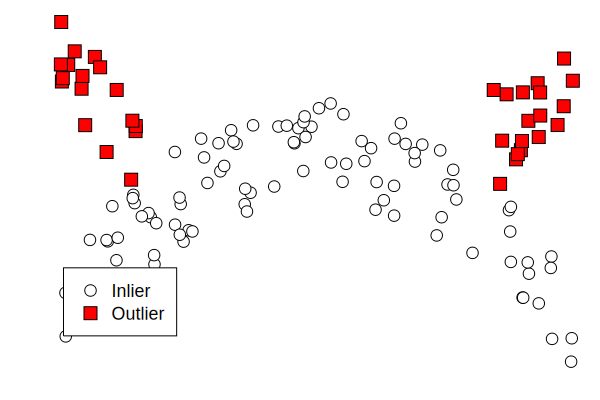

In [3]:
Random.seed!(1);
n_in, n_out = 100, 100
d_in = [[o, -(5.5(o-0.5)^2 + rand() * 0.3) + 0.5] for o in rand(Truncated(Normal(), 0.2, 0.8), n_in)]
d_out = [[o, (5.5(o-0.5)^2 + rand() * 0.3)] for o in rand(Truncated(Normal(), 0.2, 0.8), n_out)]
d_out = [[x, y] for (x, y) in d_out if (x < 0.3 || x > 0.7) && y > 0.25]
dummy_data = hcat(d_in..., d_out...)
labels = fill(:inlier, size(dummy_data,2))
labels[end-length(d_out)+1:end] .= :outlier
pools = fill(:Lin, size(dummy_data,2))
pools[end-length(d_out)+1:end] .= :Lout
scatter(dummy_data[1, pools .== :Lin], dummy_data[2, pools .== :Lin], color=[:white], marker=:circle, markersize=6, label="Inlier", axis=false, legend=:bottomleft, legendfontsize=12, grid=false)
scatter!(dummy_data[1, pools .== :Lout], dummy_data[2, pools .== :Lout], color=[:red], marker=:square, label="Outlier", markersize=6)

The white points are the inliers, and the red ones are the outliers.

In [4]:
solver = with_optimizer(Gurobi.Optimizer; OutputFlag=0);

# SVDDNeg

First learn a standard SVDDneg

[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 7.438494264988549e-15. The sum of adjustments is 9.248130203267525e-12
Academic license - for non-commercial use only
Academic license - for non-commercial use only


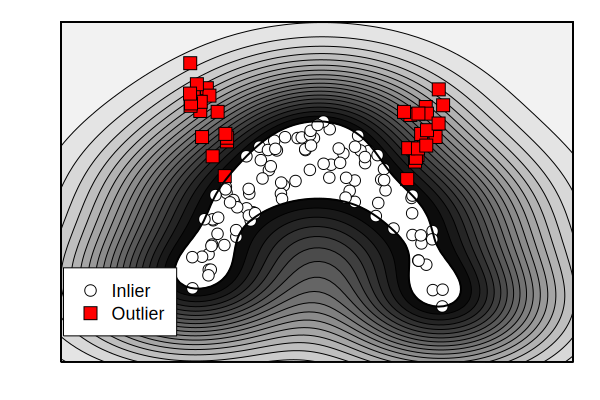

In [5]:
model_svdd = SVDD.SVDDneg(dummy_data, pools)
init_strategy = SVDD.SimpleCombinedStrategy(SVDD.FixedGammaStrategy(MLKernels.GaussianKernel(15)), SVDD.FixedCStrategy(0.95))
SVDD.initialize!(model_svdd, init_strategy)
SVDD.set_adjust_K!(model_svdd, true)
SVDD.fit!(model_svdd, solver);
SVDD.get_R_and_const_term(model_svdd)
Plots.plot(model_svdd, labels)

Generate artificial inliers and outliers [1].

[1] Wang, Siqi, et al. "Hyperparameter selection of one-class support vector machine by self-adaptive data shifting." Pattern Recognition 74 (2018): 198-211.

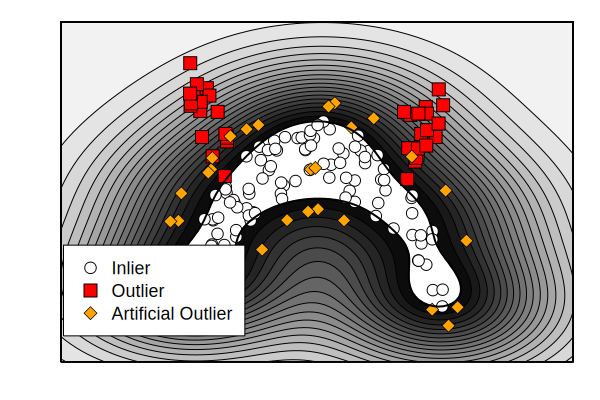

In [6]:
data_target, data_outliers = SVDD.generate_binary_data_for_tuning(dummy_data[:, labels .== :inlier])
Plots.plot(model_svdd, labels; data_outliers=data_outliers)

Here, the orange points are the artificial outliers.

We can then calculate the $\varepsilon$ by taking the largest distance of any artificial outlier to the decision boundary.

In [7]:
eps = maximum(predict(model_svdd, data_outliers))

0.050856658470573524

Now, we can extend the radius of the SVDDneg by this epsilon.

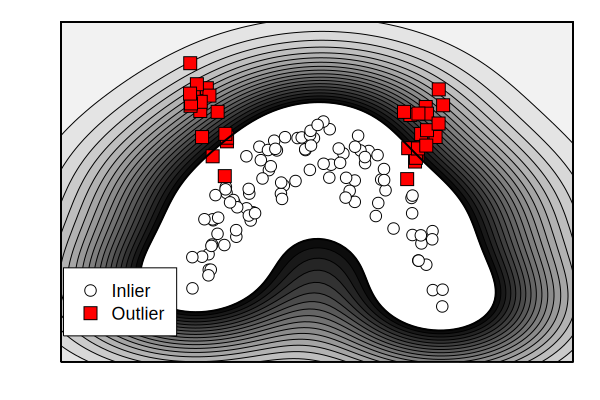

In [8]:
model_svdd_R_extended = deepcopy(model_svdd)
model_svdd_R_extended.R += eps
Plots.plot(model_svdd_R_extended, labels)

Simply extending the radius of the standard SVDDneg results in all outliers being on the wrong side of the decision boundary, i.e., labeled as inliers.

## SVDDnegEps

Train the SVDDnegEps

[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 7.438494264988549e-15. The sum of adjustments is 9.248130203267525e-12
Academic license - for non-commercial use only
Academic license - for non-commercial use only


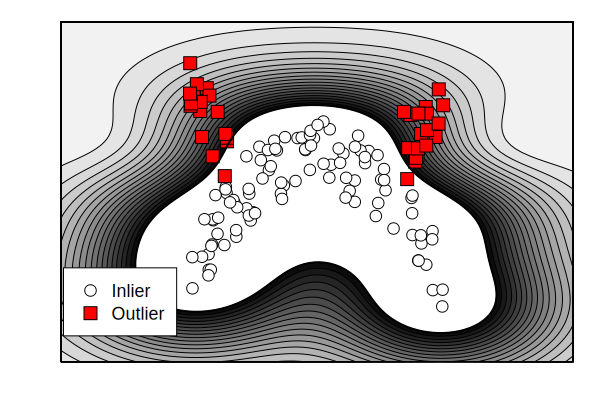

In [9]:
model = SVDD.SVDDnegEps(dummy_data, pools, eps=eps)
init_strategy = SVDD.SimpleCombinedStrategy(SVDD.FixedGammaStrategy(MLKernels.GaussianKernel(15)), SVDD.FixedCStrategy(0.95))
SVDD.initialize!(model, init_strategy)
SVDD.set_adjust_K!(model, true)
SVDD.fit!(model, solver);
SVDD.get_R_and_const_term(model)
Plots.plot(model, labels)

The SVDDnegEps allows to extend the decision boundary while still respecting the outlier labels.

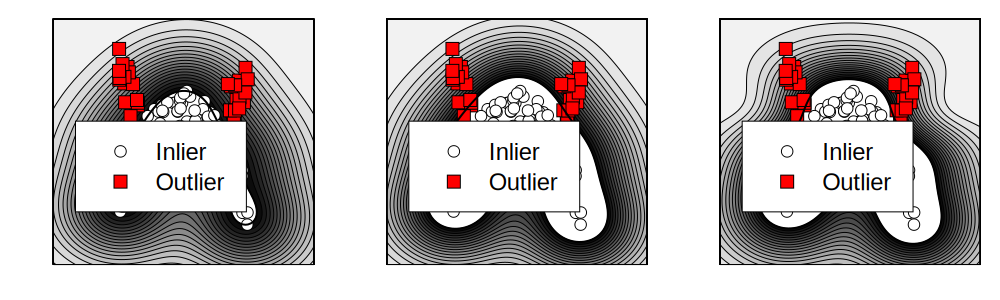

In [10]:
p1 = Plots.plot(model_svdd, labels, legendfontsize=16)
p2 = Plots.plot(model_svdd_R_extended, labels, legendfontsize=16)
p3 = Plots.plot(model, labels, legendfontsize=16)
plot(p1, p2, p3, layout=(1, 3), size=(1000, 300))

In [11]:
savefig(p1, "../plots/base_learner_01_svdd_neg.pdf")
savefig(p2, "../plots/base_learner_02_svdd_neg_naive.pdf")
savefig(p3, "../plots/base_learner_03_svdd_neg_eps.pdf")